In [107]:
from __future__ import absolute_import, division, print_function

# system imports

import sys 
import os
import requests
import argparse
import warnings

#warnings.filterwarnings("ignore")

#if not sys.warnoptions:
    
#    warnings.simplefilter("ignore")

# torch and timm imports

import torch
from torch.optim import *

# If diff timm version is installed: os.system("pip3 install timm==0.4.5")

import timm
assert timm.__version__ == "0.4.5"

# local imports and utils

import models_mae
from universal_mae_helpers import load_model, get_cuda_devices, get_out_dir, initialize_visual_cue, get_optimizer
from universal_mae_trainer import train
from util.datasets import * 
import config

# plotting and other general imports

from matplotlib import pyplot as plt 
import numpy as np
import pickle 
from distutils.util import strtobool
from PIL import Image
from colorama import Fore, Style

# logging tools

from comet_ml import Experiment
from util.datasets import make_dataset

In [108]:
model, _               = load_model(ViT_mode='large', prompt=True)

<All keys matched successfully>
Model loaded.
Model promptified.


In [109]:
#state = torch.load("models/oxford-pets/segmentation/large.pth") #"models/maze/path_finding_5x5/large.pth")
#state = torch.load("models/oxford-pets/detection/large.pth")
#state = torch.load("models/oxford-pets/classification/large.pth")
state = torch.load("models/oxford-pets/path_finding_5x5/large.pth")


model.load_state_dict(state)

<All keys matched successfully>

In [110]:
if torch.cuda.device_count() > 1:
        
    model = torch.nn.DataParallel(model, device_ids=[0,1])

In [111]:
#file                   = open("./prompts/oxford-pets/frozen/segmentation/large.p", "rb") #open('prompts/maze/finetuned/path_finding_5x5/large.p', 'rb')
#file                   = open("./prompts/oxford-pets/frozen/detection/large.p", "rb")
#file                   = open("./prompts/oxford-pets/frozen/classification/large.p", "rb")
from models_language import VisualCue
state = torch.load("./prompts/oxford-pets/frozen/path_finding_5x5/large.pth")
visual_cue_model             = VisualCue(224)
visual_cue_model.load_state_dict(state)
visual_cue_model = visual_cue_model.to(get_cuda_devices())               

In [112]:
#data_test = iter(make_dataset(dataset_name="oxford-pets", batch_size=16, dataset_path="data/oxford-pets", image_size=112, split="test"))

#data_test              = iter(make_dataset["single_task"](dataset_name="oxford-pets", task="segmentation", batch_size=16, split="test"))
#data_test              = iter(make_dataset["single_task"](dataset_name="oxford-pets", task="detection", batch_size=16, split="test"))
#data_test              = iter(make_dataset["single_task"](dataset_name="oxford-pets", task="classification", batch_size=16, split="test"))
data_test  = iter(make_dataset["single_task"](dataset_name="oxford-pets", task="multi-task", batch_size=16, split="test"))
#data_train, data_val   = make_dataset["single_task"](dataset_name="oxford-pets", task="segmentation", batch_size=16, split="trainval")

sample:3680
g_task_id:False


In [113]:
data_batch            = next(data_test) #next(iter(data_train)) #
print(data_batch[0].shape)
#train                   = torch.cat([torch.einsum("nchw->nhwc", data_batch[0]), visual_cue[label_batch, :, :, :]], dim=2) 

torch.Size([16, 3, 112, 112])


In [114]:
language = 'detect cat'
from dataset.pets import build_token_dict,word_token2idx
word_token = build_token_dict('language_word.txt')
lan_token = torch.tensor([word_token2idx(language, word_token)]).repeat(16, 1)
lan_token
lan_token.shape

torch.Size([16, 20])

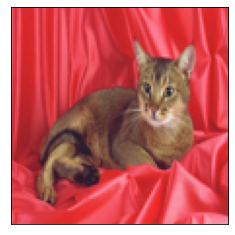

In [115]:
raw_img                = torch.einsum("chw->hwc", data_batch[0][6, :, :, :]) #data_test[50, :, :, :] 

plt.figure(figsize=(4, 4))

fig        = plt.imshow(raw_img)

fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [116]:

from skimage.transform import resize
from universal_mae_helpers import *

con_data_batch = [torch.cat([data_batch[0], data_batch[0]], dim=2)]
print(con_data_batch[0].shape)
# print("visual_cue_model_device:", visual_cue_model.device)

test_img   = stitch_visual_collage((con_data_batch,lan_token), visual_cue_model, 16, True, "hwc").detach()[5, :, :, :] #torch.cat([raw_img, visual_cue[0, :, :, :]], dim=1).detach() #
test_img   = test_img.cpu()
test_img   = test_img - imagenet_mean
test_img   = test_img / imagenet_std


torch.Size([16, 3, 224, 112])


In [120]:
torch.manual_seed(2)

#model.cuda()

print('MAE with pixel reconstruction:')
reconstructed_frame = run_one_image(test_img, model)

MAE with pixel reconstruction:


RuntimeError: The size of tensor a (224) must match the size of tensor b (3) at non-singleton dimension 3

In [ ]:
# clean up all functions
# AdamW optimizers

# Visualization function
# metrics and post-processing
# Prompt retrieval function
# push new repo

# multi-task

In [16]:
def prompt_reconstruction(self, x, mask_ratio):

    """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
    """

    N, L, D     = x.shape  # batch, length, dim
    len_keep    = int(L * (1 - mask_ratio))
    
    noise       = torch.arange(1, L+1).type(torch.int64).view(1, -1).to(config.device) #torch.rand(N, L, device=x.device)  # noise in [0, 1]

    all_ids     = set(list(np.arange(0, L))) 
    ids_remove  = set(list(np.arange(0, L).reshape(config.NUM_PATCHES, config.NUM_PATCHES)[int(config.NUM_PATCHES/2):, :int(config.NUM_PATCHES/2)].reshape(-1,)))
    ids_to_keep = all_ids - ids_remove

    ids_shuffle = torch.Tensor(np.array(list(ids_to_keep) + list(ids_remove))).type(torch.int64).view(1, -1).to(config.device)
    ids_restore = torch.argsort(ids_shuffle, dim=1)
    ids_restore = ids_restore.repeat(N, 1)

    len_keep    = len(list(ids_to_keep))
    ids_keep    = torch.Tensor(np.array(list(ids_to_keep))).type(torch.int64).view(1, -1).to(config.device)

    ids_keep    = ids_keep.repeat(N, 1)

    x_masked    = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))


    # generate the binary mask: 0 is keep, 1 is remove
    mask               = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0

    # unshuffle to get the binary mask
    mask               = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, mask, ids_restore


def promptify(model):
    
    model.random_masking = types.MethodType(prompted_masking, model)
    
    return model


In [5]:
from util.datasets import * 

In [6]:
data_loader = build_multitask_dataset(["maze", "maze"], task=["path_finding_5x5", "path_finding_10x10"], split="val", batch_size=1)

In [7]:
valid_loader = data_loader if False else zip(data_loader[0], data_loader[1])

In [ ]:
dummy = 0

for _data in valid_loader:
    
    dummy += 1
    
    print(dummy)

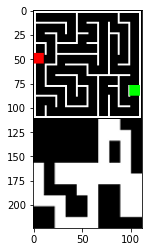

In [13]:
from matplotlib import pyplot as plt

plt.imshow(torch.einsum("chw->hwc", _data[0][0][0, :, :, :]))

In [16]:
_data[1]

tensor([1])